In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import r2_score

if torch.cuda.is_available():    
    device = "cuda:0"
else:
    device = "cpu"
print(device)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim

cpu


In [2]:
initial_channels = 128
class CNNEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(CNNEncoder, self).__init__()
        self.latent_dim = latent_dim

        layers = [
            nn.Conv1d(1, initial_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU()
        ]

        in_channels = initial_channels
        for i in range(3):  # 3 more layers to make 4 in total
            out_channels = in_channels // 2
            layers.extend([
                nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU()
            ])
            in_channels = out_channels

        self.encoder = nn.Sequential(*layers)
        self.fc_mean = nn.Linear(in_channels * seq_length, latent_dim)
        self.fc_logvar = nn.Linear(in_channels * seq_length, latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar

class CNNDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(CNNDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.fc = nn.Linear(latent_dim, initial_channels // 8 * seq_length)  # Match the output channel of the encoder

        layers = [nn.LeakyReLU()]
        in_channels = initial_channels // 8
        for i in range(3):
            out_channels = in_channels * 2
            layers.extend([
                nn.ConvTranspose1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU()
            ])
            in_channels = out_channels
        
        # Remove the last LeakyReLU and add a final ConvTranspose to match the Encoder's starting channel
        layers.pop()
        layers.append(nn.ConvTranspose1d(in_channels, 1, kernel_size=3, stride=1, padding=1))

        self.decoder = nn.Sequential(*layers)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), initial_channels // 8, seq_length)
        x = self.decoder(x)
        return F.leaky_relu(x)


class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = CNNEncoder(latent_dim)
        self.decoder = CNNDecoder(latent_dim)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        reconstruction = self.decoder(z)
        return reconstruction, mean, logvar
    
    def get_embedding(self, x):
        self.eval()
        with torch.no_grad():
            mean, logvar = self.encoder(x)
            z = self.reparameterize(mean, logvar)
        return z

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train(model, dataloader, optimizer, criterion, alpha):
    model.train()
    running_loss = 0
    for data in dataloader:
        data = data.to(device)
        optimizer.zero_grad()

        reconstruction, mean, logvar = model(data)
        recon_loss = criterion(reconstruction, data)
        kl_loss = -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())
        loss = recon_loss + alpha * kl_loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)
        
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def test(model, dataloader, criterion):
    model.eval()
    running_loss = 0
    with torch.no_grad():
        for data in dataloader:
            data = data.to(device)
            reconstruction, _, _ = model(data)
            loss = criterion(reconstruction, data)

            running_loss += loss.item() * data.size(0)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def get_latent_variables(model, dataloader):
    model.eval()
    all_latent_vars = []
    with torch.no_grad():
        for data in dataloader:
            # 从 DataLoader 中提取张量数据，去掉标签部分
            data = data[0].to(device)  # data[0] 提取数据部分，忽略标签
            _, mean, _ = model(data)
            all_latent_vars.append(mean.detach().cpu())
    return torch.cat(all_latent_vars)

In [3]:
# 采样率 (每秒2次，即2Hz)
sampling_rate = 2  # 2Hz
max_duration = 5 * 60  # 最长5分钟，单位为秒
max_length = max_duration * sampling_rate  # 最大数据点数

# 定义模型的参数
latent_dim = 10  # 潜在空间维度
initial_channels = 128  # 初始的通道数量
seq_length = max_length  # 每个样本的长度，即 600 个数据点

In [4]:
# 加载 VAE 模型
latent_dim = 10  # 和之前保持一致
vae_model = VAE(latent_dim)
vae_model.load_state_dict(torch.load('vae_model_2.pth'))
vae_model = vae_model.to(device)
vae_model.eval()
print("VAE model loaded and ready for processing new data.")

VAE model loaded and ready for processing new data.


In [5]:
import os
import pandas as pd
import numpy as np
import torch

# 读取 valid_patients_outcome.csv 文件
valid_outcome_data = pd.read_csv('valid_patients_outcome.csv')

# 获取 valid_patients 中的 pat_ID
valid_patients = valid_outcome_data['pat_ID'].unique()

# 文件夹路径
folder_path = '5min_smoothed_data/'
sampling_rate = 2  # 2Hz
max_duration = 5 * 60  # 最长5分钟，单位为秒
max_length = max_duration * sampling_rate  # 最大数据点数

# 初始化列表用于存储处理后的数据和对应的 outcome
bci_data_list = []
outcome_list = []

# 遍历文件夹中的每个 CSV 文件
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        patient_id = filename.split('.')[0]
        
        # 仅处理 valid_patients 中的病人
        if patient_id in valid_patients:
            # 读取 EEG 数据
            file_path = os.path.join(folder_path, filename)
            eeg_data = pd.read_csv(file_path)
            
            # 提取 BCI 数据
            bci_series = eeg_data['BCI'].values
            
            # 中心化处理
            current_length = len(bci_series)
            if current_length < max_length:
                pad_size = max_length - current_length
                left_pad = pad_size // 2
                right_pad = pad_size - left_pad
                bci_series = np.pad(bci_series, (left_pad, right_pad), 'constant', constant_values=-1)
            elif current_length > max_length:
                start_index = (current_length - max_length) // 2
                bci_series = bci_series[start_index:start_index + max_length]

            # 添加数据到列表
            bci_data_list.append(bci_series)
            
            # 获取该病人的 outcome（转换为 0 和 1）
            outcome = valid_outcome_data[valid_outcome_data['pat_ID'] == patient_id]['outcome'].values[0]
            outcome_list.append(1 if outcome == 'Good Outcome' else 0)

# 转换为 numpy 数组，并转换为 PyTorch 张量
bci_data_array = np.array(bci_data_list)
bci_data_tensor = torch.tensor(bci_data_array, dtype=torch.float32).unsqueeze(1)  # 增加 channel 维度

# 输出数据形状
print(f"Processed BCI data shape: {bci_data_tensor.shape}")  # 应为 (样本数量, 1, 600)

Processed BCI data shape: torch.Size([298, 1, 600])


In [6]:
# 创建 DataLoader
batch_size = 32
dataset = TensorDataset(bci_data_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# 获取隐藏变量
latent_variables = get_latent_variables(vae_model, dataloader)

# 转换为 DataFrame，并添加 outcome 标签
latent_variables_df = pd.DataFrame(latent_variables.numpy())
latent_variables_df['outcome'] = outcome_list

# 输出隐藏变量数据形状和样本示例
print(latent_variables_df.head())
print(f"Latent variables shape: {latent_variables_df.shape}")

           0          1          2          3          4          5  \
0  21.736076 -29.607956  -8.544381  30.190256 -23.334476  19.080908   
1 -16.380611   2.010826  -0.143143  -2.174988  -8.572595   8.543261   
2   4.948158 -22.019794 -13.004012  18.681240 -26.820051  33.444889   
3  15.797303 -27.067341 -16.768808  25.729410 -26.618563  29.023897   
4 -12.610763  -3.133034   0.584102   5.645677 -17.353233  21.954288   

           6          7          8          9  outcome  
0 -22.083412  31.280226 -16.598841 -24.870436        0  
1  20.295631  -5.306662  -1.424239  -1.452446        0  
2  -4.235742   1.821972 -18.301687 -33.841778        0  
3 -18.581293  19.255016 -15.383933 -29.786531        0  
4  19.554018 -11.261367 -14.039392 -22.632565        0  
Latent variables shape: (298, 11)


In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assume `latent_variables_df` is your DataFrame with latent variables and 'outcome' column
# X represents the features (latent variables), and y represents the outcome labels.
X = latent_variables_df.drop(columns=['outcome']).values  # Use latent variables as features
y = latent_variables_df['outcome'].values  # Use 'outcome' as labels

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train the SVM model
svm_model = SVC(kernel='rbf', C=1.0, random_state=42)
svm_model.fit(X_train, y_train)

# Predict outcomes on the test set
y_pred = svm_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Generate a classification report
report = classification_report(y_test, y_pred)

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print(f"Accuracy of SVM on latent_variables 10-dimensional BCI data: {accuracy:.4f}")
print("\nClassification Report:")
print(report)
print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy of SVM on latent_variables 10-dimensional BCI data: 0.8333

Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        75
           1       0.00      0.00      0.00        15

    accuracy                           0.83        90
   macro avg       0.42      0.50      0.45        90
weighted avg       0.69      0.83      0.76        90


Confusion Matrix:
[[75  0]
 [15  0]]


/Users/yinziyuan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yinziyuan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yinziyuan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assume `bci_data_array` is your original data of shape (samples, 600) and `outcome_list` is the label list (0 or 1)
# Convert outcome_list to a numpy array for compatibility with scikit-learn
outcomes = np.array(outcome_list)

# Split data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(bci_data_array, outcomes, test_size=0.3, random_state=42)

# Standardize the data to have zero mean and unit variance, which is essential for SVM
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define and train the SVM model
svm_model = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)

# Predict outcomes on the test set
y_pred = svm_model.predict(X_test)

# Evaluate the SVM model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy of SVM on original 600-dimensional BCI data: {accuracy:.4f}")
print("\nClassification Report:")
print(report)
print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy of SVM on original 600-dimensional BCI data: 0.8333

Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        75
           1       0.00      0.00      0.00        15

    accuracy                           0.83        90
   macro avg       0.42      0.50      0.45        90
weighted avg       0.69      0.83      0.76        90


Confusion Matrix:
[[75  0]
 [15  0]]


/Users/yinziyuan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yinziyuan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yinziyuan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
# Use latent variables as X
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Define X and y
X = latent_variables_df.drop(columns=['outcome']).values 
y = np.array(outcome_list)  # Use the corresponding outcomes

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Check the distribution to ensure stratification
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Testing set class distribution: {np.bincount(y_test)}")

# Create and train the SVM model with class balancing
svm_model = SVC(kernel='rbf', C=1.0, class_weight='balanced', random_state=42)
svm_model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy of SVM on latent_variables 10-dimensional BCI data: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Training set class distribution: [172  36]
Testing set class distribution: [74 16]
Accuracy of SVM on latent_variables 10-dimensional BCI data: 0.5778

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.55      0.68        74
           1       0.25      0.69      0.37        16

    accuracy                           0.58        90
   macro avg       0.57      0.62      0.53        90
weighted avg       0.78      0.58      0.63        90


Confusion Matrix:
[[41 33]
 [ 5 11]]


In [10]:
# Use original variables as X
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define X and y
X = bci_data_tensor.squeeze(1).numpy()  # Using the original 600-dimensional data as an example
y = np.array(outcome_list)  # Use the corresponding outcomes

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Check the distribution to ensure stratification
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Testing set class distribution: {np.bincount(y_test)}")

# Create and train the SVM model with class balancing
svm_model = SVC(kernel='rbf', C=1.0, class_weight='balanced', random_state=42)
svm_model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy of SVM on original 600-dimensional BCI data: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Training set class distribution: [172  36]
Testing set class distribution: [74 16]
Accuracy of SVM on original 600-dimensional BCI data: 0.5556

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.53      0.66        74
           1       0.24      0.69      0.35        16

    accuracy                           0.56        90
   macro avg       0.56      0.61      0.51        90
weighted avg       0.77      0.56      0.61        90


Confusion Matrix:
[[39 35]
 [ 5 11]]


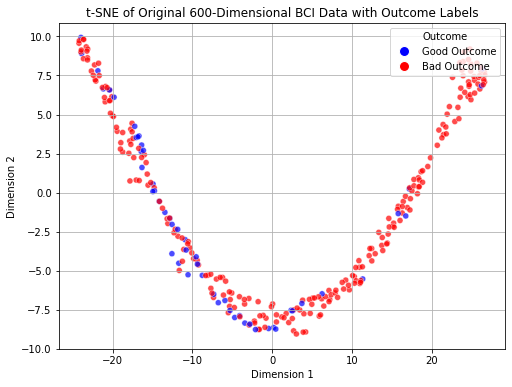

In [28]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# 使用 t-SNE 将潜在变量降维到 2D
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_variables_df.drop(columns=['outcome']))

# 将降维后的结果转换为 DataFrame，并添加 outcome 标签
latent_2d_df = pd.DataFrame(latent_2d, columns=['Dim1', 'Dim2'])
latent_2d_df['outcome'] = latent_variables_df['outcome']

# 使用 t-SNE 的结果绘制散点图
plt.figure(figsize=(8, 6))

# 使用自定义的颜色映射，确保 'Good Outcome' 和 'Bad Outcome' 对应正确的颜色
sns.scatterplot(
    x='Dim1', y='Dim2', 
    hue='outcome', 
    data=latent_2d_df, 
    palette={1: 'blue', 0: 'red'},  # 确保 Good Outcome 为蓝色，Bad Outcome 为红色
    alpha=0.7,
    legend=False  # 禁用自动生成的图例
)

# 手动创建图例
from matplotlib.lines import Line2D
legend_labels = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Good Outcome'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Bad Outcome')
]
plt.legend(handles=legend_labels, title='Outcome', loc='upper right')

# 设置标题和标签
plt.title('t-SNE of Original 600-Dimensional BCI Data with Outcome Labels')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

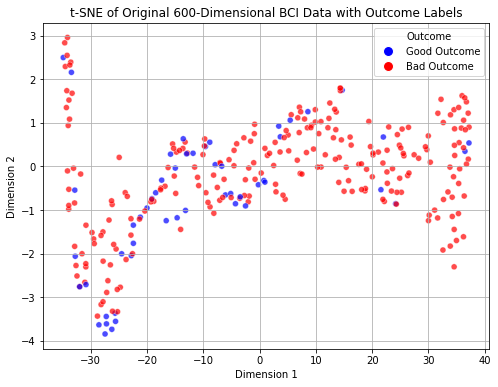

In [24]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# 原始的 BCI 数据形状为 (样本数量, 600)，因此我们需要将其转换为 2D
# 我们已经有 bci_data_array，它的形状是 (样本数量, 600)

# 使用 t-SNE 将原始 600 维数据降维到 2D
tsne = TSNE(n_components=2, random_state=42)
bci_2d = tsne.fit_transform(bci_data_array)

# 将降维后的结果转换为 DataFrame，并添加 outcome 标签
bci_2d_df = pd.DataFrame(bci_2d, columns=['Dim1', 'Dim2'])
bci_2d_df['outcome'] = outcome_list  # 添加 outcome 标签

# 使用 t-SNE 的结果绘制散点图
plt.figure(figsize=(8, 6))

# 使用自定义的颜色映射，确保 'Good Outcome' 和 'Bad Outcome' 对应正确的颜色
sns.scatterplot(
    x='Dim1', y='Dim2', 
    hue='outcome', 
    data=bci_2d_df, 
    palette={1: 'blue', 0: 'red'},  # 确保 Good Outcome 为蓝色，Bad Outcome 为红色
    alpha=0.7,
    legend=False  # 禁用自动生成的图例
)

# 手动创建图例
from matplotlib.lines import Line2D
legend_labels = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Good Outcome'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Bad Outcome')
]
plt.legend(handles=legend_labels, title='Outcome', loc='upper right')

# 设置标题和标签
plt.title('t-SNE of Original 600-Dimensional BCI Data with Outcome Labels')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()